In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh_local')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
mavenn.__path__

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh_local/mavenn']

In [3]:
!pwd

/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/2021_nature_methods_redo/Figure_6


In [4]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 9,935
training + validation N: 40,583


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,training,0,1,0,0,0,0,0,0,0,0,AAAAAAAGTGAGTTAGCCAACTAATTAGGCACCGTACGCTTTATAG...
1,training,0,0,0,0,0,0,0,0,0,1,AAAAAATGAGAGTTAGTTCACTCATTCGGCACCACAGGCTTTACAA...
2,training,0,0,0,0,0,0,0,0,0,1,AAAAAATGGGTGTTAGCTCTATCATTAGGCACCCCCGGCTTTACAC...
3,training,0,1,0,0,0,0,0,0,0,0,AAAAAATGTCAGTTAGCTGACTCATTAGGCACCCCTGGCTTTACGT...
4,validation,0,0,0,0,0,0,1,0,0,0,AAAAAATGTGAGAAAGCTCACTCCTTTGGCACCGCAGGCTTTACAC...


In [5]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=75, Y=10


In [6]:
from mavenn.src.layers.gpmap import GPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense

class ThermodynamicLayer(GPMapLayer):
    """Represents an thermodynamic model of transcription
       regulation in E. Coli at the lac promoter, which 
       contains binding sites for RNAP and CRP.
    """

    def __init__(self, 
                 TF_start,
                 TF_end,
                 RNAP_start,
                 RNAP_end,
                 regularizer, 
                 *args, **kwargs):
        """Construct layer instance."""
        
        # set attributes
        self.TF_start = TF_start
        self.TF_end = TF_end        
        self.RNAP_start = RNAP_start
        self.RNAP_end = RNAP_end        
        self.C=kwargs['C']
        self.regularizer = tf.keras.regularizers.L2(regularizer)
        
        # form helpful variables
        self.L_TF = TF_end-TF_start
        self.L_RNAP = RNAP_end - RNAP_start
        
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""
        
        # define bias/chemical potential weight for crp
        self.mu_TF = self.add_weight(name='mu_TF',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)

        # define bias/chemical potential weight for rnap
        self.mu_RNAP = self.add_weight(name='mu_RNAP',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)


        # Define theta_TF_lc parameters
        theta_TF_lc_shape = (1, self.L_TF, self.C)

        theta_TF_lc_init = np.random.randn(*theta_TF_lc_shape)/np.sqrt(self.L_TF)
        self.theta_TF_lc = self.add_weight(name='theta_TF_lc',
                                        shape=theta_TF_lc_shape,
                                        #initializer=Constant(theta_TF_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        
        # Define theta_rnap_lc parameters
        theta_RNAP_lc_shape = (1, self.L_RNAP, self.C)

        theta_RNAP_lc_init = np.random.randn(*theta_RNAP_lc_shape)/np.sqrt(self.L_RNAP)
        self.theta_RNAP_lc = self.add_weight(name='theta_RNAP_lc',
                                        shape=theta_RNAP_lc_shape,
                                        #initializer=Constant(theta_RNAP_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        
        # define interaction term. Not sure if this needs regularization
        self.interaction = self.add_weight(name='interaction',
                               shape=(1,),
                               initializer=Constant(0),
                               trainable=True,
                               regularizer=tf.keras.regularizers.L2(0))
        
        # define tsat term. Not sure if this needs regularization
        self.tsat = self.add_weight(name='tsat',
                               shape=(1,),
                               initializer=Constant(1.),
                               trainable=True,
                               regularizer=tf.keras.regularizers.L2(0))        
        
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output.
        
        x_lc: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """
        
        # extract locations of binding sites from entire lac-promoter sequence.
        x_TF_lc = x_lc[:,self.C * self.TF_start:self.C * self.TF_end]
        x_RNAP_lc = x_lc[:,self.C * self.RNAP_start: self.C * self.RNAP_end]
        
        # reshape according to crp and rnap lengths. 
        x_TF_lc = tf.reshape(x_TF_lc, [-1, self.L_TF, self.C])
        x_RNAP_lc = tf.reshape(x_RNAP_lc, [-1, self.L_RNAP, self.C])
                
        # compute delta G for crp    
        phi_TF = self.mu_TF + \
              tf.reshape(K.sum(self.theta_TF_lc * x_TF_lc, axis=[1, 2]),
                         shape=[-1, 1])
            
        # compute delta G for rnap
        phi_RNAP = self.mu_RNAP + \
              tf.reshape(K.sum(self.theta_RNAP_lc * x_RNAP_lc, axis=[1, 2]),
                         shape=[-1, 1])            
        
        # compute rate of transcription
        t = (self.tsat)*(K.exp(-phi_RNAP)+K.exp(-phi_TF-phi_RNAP-self.interaction))/(1+K.exp(-phi_TF)+K.exp(-phi_RNAP)+K.exp(-phi_TF-phi_RNAP-self.interaction))
        
        # return rate of transcription
        return t


In [7]:
# define custom gp_map parameters dictionary
gpmap_kwargs = {'L':L,
                'C':4,
                'theta_regularization': 0.1,
                'TF_start':1,
                'TF_end':27,
                'RNAP_start':34,
                'RNAP_end':75,
                'C':4,
                'regularizer':0.1}



In [76]:
for model_number in range(10):

    # Create model
    model = mavenn.Model(L=L, 
                         Y=Y,
                         alphabet='dna', 
                         regression_type='MPA', 
                         gpmap_type='custom',
                         gpmap_kwargs=gpmap_kwargs,
                         custom_gpmap=ThermodynamicLayer)

    # Set training data
    model.set_data(x=data_df['x'],
                   y=data_df[y_cols],
                   validation_flags=(data_df['set']=='validation'),
                   verbose=False,
                   shuffle=True)

    # Fit model to data
    model.fit(learning_rate=.001,
              epochs=1000,
              batch_size=300,
              verbose=False,
              early_stopping=True,
              try_tqdm=False,
              early_stopping_patience=25,
              linear_initialization=False)
    
    #print(f'model number = {model_number}')
    x_test = test_df['x'].values
    y_test = test_df[y_cols].values

    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    #print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
    #print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

    I_var_hist = model.history['I_var']
    val_I_var_hist = model.history['val_I_var']

    interaction_term = model.get_nn().layers[2].get_weights()[4]
    crp_weights = model.get_nn().layers[2].get_weights()[2][0]
    rnap_weights = model.get_nn().layers[2].get_weights()[3][0]
    print(f'model number = {model_number}, interaction term = {interaction_term[0]*0.62:.3f} k_cal/mol, I_pred_test: {I_pred:.3f}, I_var_test: {I_var:.3f}')

    model.save(f'21.12.20.models_sortseq/sortseq_model_{model_number}_I_{interaction_term[0]*0.62:.3f}',verbose=False)

In [ ]:
#model.save('21.12.20.models_sortseq/model_I_-3.61_kcal_mol')

In [85]:
model = mavenn.load('21.12.20.models_sortseq/sortseq_model_0_I_-3.121')

Model loaded from these files:
	21.12.20.models_sortseq/sortseq_model_0_I_-3.121.pickle
	21.12.20.models_sortseq/sortseq_model_0_I_-3.121.h5


On test data:
I_var_test: 0.688 +- 0.011 bits
I_pred_test: 0.717 +- 0.009 bits


Text(0.5, 1.0, 'training hisotry')

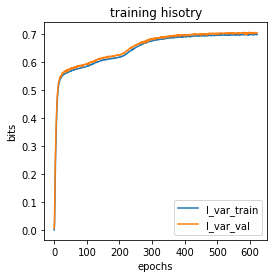

In [86]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
#ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
#ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

In [87]:
interaction_term = model.get_nn().layers[2].get_weights()[4]
crp_weights = model.get_nn().layers[2].get_weights()[2][0]
rnap_weights = model.get_nn().layers[2].get_weights()[3][0]
print(f'interaction term = {interaction_term[0]*0.62:.3f} k_cal/mol')

interaction term = -3.121 k_cal/mol


In [88]:
# if I_pred > 0.7:
#     model.save(f'sort_seq_2010_models/model_{I_pred:.3f}_bits_I_{interaction_term[0]*0.62:.3f}_kcal_mol')

In [89]:
tsat_true = model.get_nn().layers[2].get_weights()[5][0]
tsat_true

8.35454

In [90]:
crp_df = pd.DataFrame(crp_weights,columns=model.alphabet)
rnap_df = pd.DataFrame(rnap_weights,columns=model.alphabet)

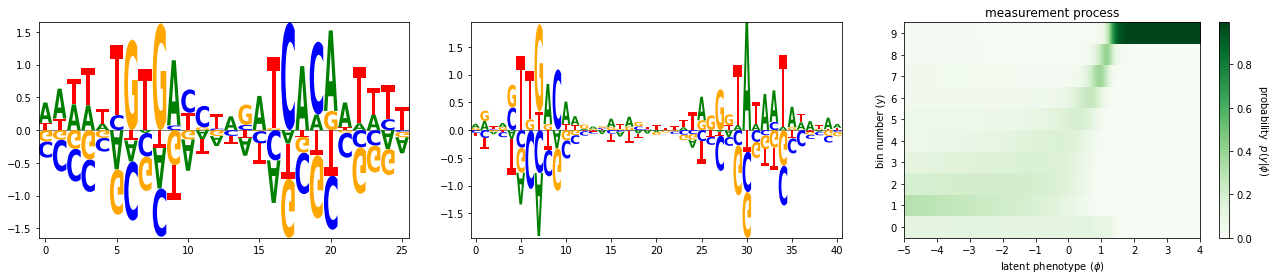

In [91]:
# # Get G-P map parameters in matrix form
# theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 4]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# # Create figure with two panels
fig, axs = plt.subplots(1,3,figsize=[18,4])

logomaker.Logo(crp_df,ax=axs[0],center_values=True)
logomaker.Logo(rnap_df,ax=axs[1],center_values=True)

# # Right panel: draw measurement process as heatmap
ax = axs[2]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('thermodynmic_custom_gpmap_mpa_visualization_sort_seq.png',bbox_index='tight',dpi=300)
# plt.show()

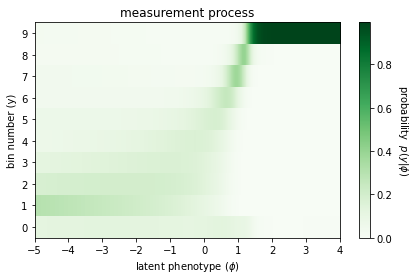

In [92]:
fig, ax = plt.subplots()
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('measurement_process_sort_seq_2010.png',bbox_index='tight',dpi=300)

In [121]:
number_of_seqs_to_simulate = 51000
G_I = []
number_simulations = 2
for model_number in range(number_simulations):
    
    sim_df_new = model.simulate_dataset(number_of_seqs_to_simulate)
    #sim_df_new.to_csv(f'sim_dfs_xylE/sim_df_{model_number}.csv.gz')
    
    y_cols_sim = sim_df_new.columns[1:-1]
    # Separate test from data_df
    ix_test = sim_df_new['set']=='test'
    test_df = sim_df_new[ix_test].reset_index(drop=True)
    #print(f'test N: {len(test_df):,}')

    # Remove test data from data_df
    sim_df_new = sim_df_new[~ix_test].reset_index(drop=True)
    #print(f'training + validation N: {len(sim_df_new):,}')
    #sim_df.head()
    
    # Create model
    sim_model = mavenn.Model(L=L, 
                             Y=Y,
                             alphabet='dna', 
                             regression_type='MPA', 
                             gpmap_type='custom',
                             gpmap_kwargs=gpmap_kwargs,
                             custom_gpmap=ThermodynamicLayer)
    
    # Set training data
    sim_model.set_data(x=sim_df_new['x'],
                       y=sim_df_new[y_cols],
                       validation_flags=(sim_df_new['set']=='validation'),
                       shuffle=True)

    # Fit model to data
    sim_model.fit(learning_rate=.001,
                  epochs=1000,
                  batch_size=300,
                  early_stopping=True,
                  early_stopping_patience=25,
                  linear_initialization=False)
    
    interaction_term_sim = sim_model.get_nn().layers[2].get_weights()[4]
    
    if interaction_term_sim[0] < 0:
        print(f'interaction term = {interaction_term_sim[0]/1.688:.3f} k_cal/mol')
        G_I.append(interaction_term_sim[0]*0.62)

        sim_model.save(f'21.12.20.simulation_models_sortseq/sim_model_{model_number}', verbose=False)

In [124]:
np.std(GI)/np.sqrt(number_simulations)

2.200175128022763

In [125]:
sim_model = mavenn.load('21.12.20.simulation_models_sortseq/sim_model_0')

Model loaded from these files:
	21.12.20.simulation_models_sortseq/sim_model_0.pickle
	21.12.20.simulation_models_sortseq/sim_model_0.h5


On test data:
I_var_test: 0.608 +- 0.011 bits
I_pred_test: 0.624 +- 0.014 bits


Text(0.5, 1.0, 'training hisotry')

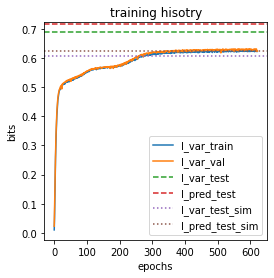

In [126]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values

# Compute likelihood information
I_var_sim, dI_var_sim =  sim_model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var_sim:.3f} +- {dI_var_sim:.3f} bits') 

# Compute predictive information
I_pred_sim, dI_pred_sim = sim_model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred_sim:.3f} +- {dI_pred_sim:.3f} bits')

I_var_hist_sim = sim_model.history['I_var']
val_I_var_hist_sim = sim_model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist_sim, label='I_var_train')
ax.plot(val_I_var_hist_sim, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle='--', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle='--', label='I_pred_test')

ax.axhline(I_var_sim, color='C4', linestyle=':', label='I_var_test_sim')
ax.axhline(I_pred_sim, color='C5', linestyle=':', label='I_pred_test_sim')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

In [127]:
interaction_term_sim = sim_model.get_nn().layers[2].get_weights()[4]
crp_weights_sim = sim_model.get_nn().layers[2].get_weights()[2][0]
rnap_weights_sim = sim_model.get_nn().layers[2].get_weights()[3][0]
print(f'interaction term = {interaction_term_sim[0]*0.62:.3f} k_cal/mol')

interaction term = -3.157 k_cal/mol


In [128]:
tsat_sim = sim_model.get_nn().layers[2].get_weights()[5][0]
tsat_sim

8.510212

In [129]:
crp_df_sim = pd.DataFrame(crp_weights_sim,columns=model.alphabet)
rnap_df_sim = pd.DataFrame(rnap_weights_sim,columns=model.alphabet)

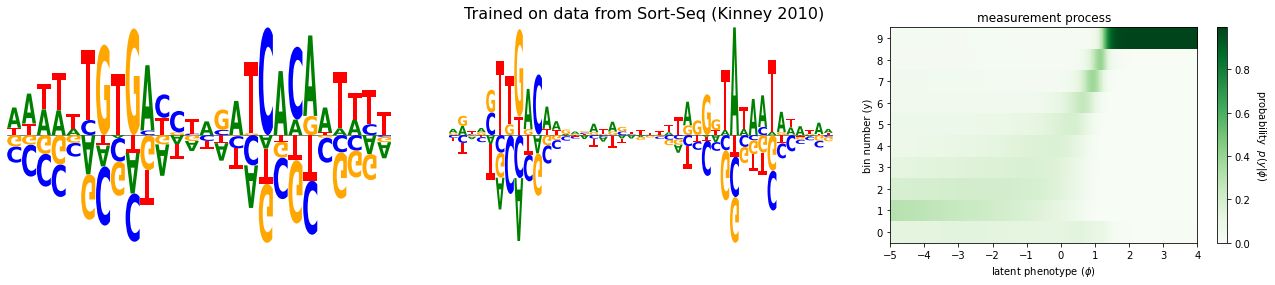

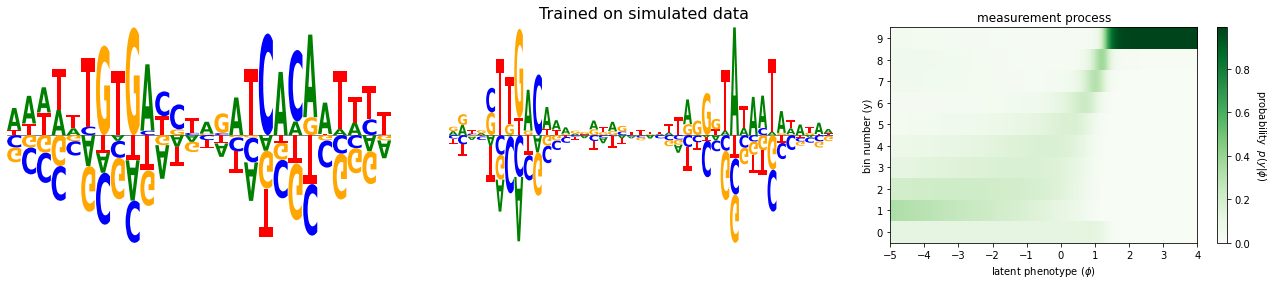

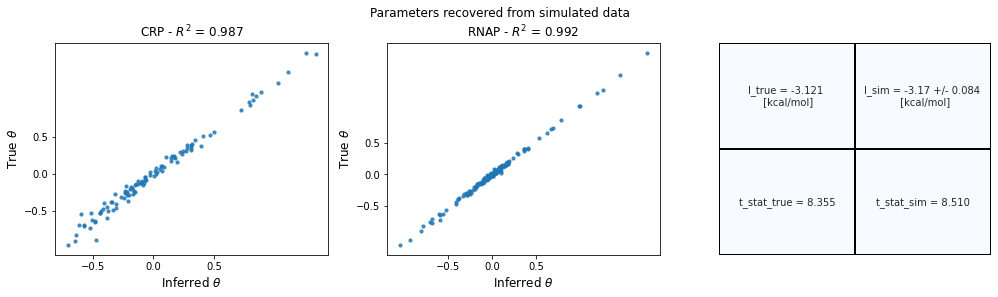

In [130]:
# # Create figure with two panels
fig, axs = plt.subplots(1,3,figsize=[18,4])

crp_logo = logomaker.Logo(crp_df,ax=axs[0],center_values=True)
crp_logo.style_spines(visible=False)
axs[0].set_xticks([])
axs[0].set_yticks([])
rnap_logo = logomaker.Logo(rnap_df,ax=axs[1],center_values=True)
rnap_logo.style_spines(visible=False)
axs[1].set_xticks([])
axs[1].set_yticks([])

# # Right panel: draw measurement process as heatmap
ax = axs[2]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

fig.suptitle('Trained on data from Sort-Seq (Kinney 2010)',fontsize=16)
# Fix up plot
fig.tight_layout(w_pad=3)

# # Get G-P map parameters in matrix form
# theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 4]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = sim_model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process_sim = sim_model.p_of_y_given_phi(y_all, phi_grid)

# # Create figure with two panels
fig, axs = plt.subplots(1,3,figsize=[18,4])

crp_logo_sim = logomaker.Logo(crp_df_sim,ax=axs[0],center_values=True)
crp_logo_sim.style_spines(visible=False)
axs[0].set_xticks([])
axs[0].set_yticks([])
rnap_logo_sim =logomaker.Logo(rnap_df_sim,ax=axs[1],center_values=True)
rnap_logo_sim.style_spines(visible=False)
axs[1].set_xticks([])
axs[1].set_yticks([])

# # Right panel: draw measurement process as heatmap
ax = axs[2]
im = ax.imshow(measurement_process_sim,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

fig.suptitle('Trained on simulated data',fontsize=16)
# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('thermodynmic_custom_gpmap_mpa_visualization_sort_seq.png',bbox_index='tight',dpi=300)
# plt.show()

fig1, axs1 = plt.subplots(1,3,figsize=[14,4])

axs1[0].scatter(crp_logo_sim.df.values.ravel(),crp_logo.df.values.ravel(),s=10,alpha=0.8,c='C0')
axs1[0].set_xlabel('Inferred $\\theta$',fontsize=12)
axs1[0].set_ylabel('True $\\theta$',fontsize=12)
Rsq_crp = np.corrcoef(crp_df_sim.values.ravel(),crp_df.values.ravel())[0][1]**2
axs1[0].set_title(f'CRP - $R^2$ = {Rsq_crp:.3f}',fontsize=12)
axs1[0].set_xticks([-0.5,0,0.5])
axs1[0].set_yticks([-0.5,0,0.5])

axs1[1].scatter(rnap_logo_sim.df.values.ravel(),rnap_logo.df.values.ravel(),s=10,alpha=0.8,c='C0')
Rsq_rnap = np.corrcoef(rnap_df_sim.values.ravel(),rnap_df.values.ravel())[0][1]**2
axs1[1].set_title(f'RNAP - $R^2$ = {Rsq_rnap:.3f}',fontsize=12)
axs1[1].set_xlabel('Inferred $\\theta$',fontsize=12)
axs1[1].set_ylabel('True $\\theta$',fontsize=12)
axs1[1].set_xticks([-0.5,0,0.5])
axs1[1].set_yticks([-0.5,0,0.5])

params = np.ones((2,2))

#labels = np.asarray([[f'I_true = {interaction_term[0]/1.688:.3f} \n [kcal/mol]', f'I_sim = {interaction_term_sim[0]/1.688:.3f} \n [kcal/mol]'],
labels = np.asarray([[f'I_true = {interaction_term[0]*0.62:.3f} \n [kcal/mol]', f'I_sim = -3.17 +/- 0.084 \n [kcal/mol]'],
            [f't_stat_true = {tsat_true:.3f}', f't_stat_sim = {tsat_sim:.3f}']])

sns.heatmap(params,
            annot=labels,
            fmt="",
            linewidths=1, 
            linecolor='black',
            cmap='Blues',
            xticklabels=[],
            yticklabels=[],
            cbar=False,
            ax=axs1[2])

fig1.suptitle('Parameters recovered from simulated data',fontsize=12,y=1.02)

#sns.heatmap(,ax=axs1[1])
fig1.tight_layout()

To estimate uncertainties, run 10 simulations in the simulation for loop above and calculate mean and std deviation of interaction, as given by pseudo-code below

In [131]:
# interaction_terms_simulations = []
# for model_index in ['1','2','3','4','5','6','7']:
#     temp_model = mavenn.load(f'simulation_models/N_50/sim_model_{model_index}',verbose=False)
#     interaction_term_sim = temp_model.get_nn().layers[2].get_weights()[4]
#     interaction_terms_simulations.append(interaction_term_sim[0]*0.62)

# np.mean(interaction_terms_simulations),np.std(interaction_terms_simulations)